In [ ]:
#install the requied libraries to support the project and run the next cell
!pip install pydicom
!pip install mock
!pip install tensorflow
!pip install seaborn
!pip install SimpleITK
!pip install med2image 
!pip install academictorrents
!pip install fastai

In [22]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from numpy import asarray
from PIL.ImageStat import Stat
from PIL import Image
import PIL.Image as Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import os
import glob
import seaborn as sns
import cv2
import random as r
import pydicom
import keras
from keras.models import model_from_json
#from cv2 import imshow 
#Above is not working for google colab as it is said notebook will collaspe. please use below import for the same
from google.colab.patches import cv2_imshow
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)
import med2image 
import academictorrents as at
from fastai.vision import Image, ImageList, get_transforms, open_image

In [3]:
#clone the github for data
! git clone https://github.com/ieee8023/covid-chestxray-dataset
#!python3

fname = '/content/covid-chestxray-dataset/volumes/volume_script.py'
data = 'at.get("136ffddd0959108becb2b3a86630bec049fcb0ff",use_timestamp=False)'

with open(fname, 'w') as f:
    f.write('import academictorrents as at\npath_of_dataset = {}'.format(data))

#download the image files    
import academictorrents as at
!python /content/covid-chestxray-dataset/volumes/volume_script.py    
!mv /root/.academictorrents-datastore/volumes/* /content/covid-chestxray-dataset/volumes/

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 34.99 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.
Torrent name: volumes, Size: 1105.13MB
Checking pieces on disk...
100% 66/66 [00:00<00:00, 74116.22it/s]
Found 0 finished pieces out of 66 total pieces.

 Download Complete!


#create the required directories 
#please chnage the directory names as per the infrastructure. below are the directory structures created for google colab. Need GPU to process the mages. as it is taking huge time on the AWS and failing with memory and space issues using google colab to test the work and later it needs to be integrated with AWS for deployment by deployment teams

In [4]:
!mkdir /content/AIML
!mkdir /content/AIML/COVID
!mkdir /content/AIML/NonCOVID
!mkdir /content/AIML/processed_cov
!mkdir /content/AIML/processed_noncov

#/home/ubuntu/Notebooks/

In [5]:
covid_path_xr = '/content/AIML/COVID'
noncovid_path_xr = '/content/AIML/NonCOVID'
images_dir = '/content/covid-chestxray-dataset/images'
volumes_dir = '/content/covid-chestxray-dataset/volumes'
git_data_dir= '/content/covid-chestxray-dataset'
aiml_dir= '/content/AIML'
proc_cov= '/content/AIML/processed_cov'
proc_noncov= '/content/AIML/processed_noncov'

In [6]:
df=pd.read_csv(git_data_dir+'/metadata.csv')
#print(df['finding'][df.finding!=covid].value_counts())
#print(df['folder'][df.finding==covid].value_counts())

In [7]:
#reusable function to copy or move the files for labelling
def mov_image(cp,img,src_path,tgt_path):
   sp=os.path.join(src_path,img)
   tp=os.path.join(tgt_path,img)
   if cp=='cp':
     shutil.copy(sp, tp)
   else :
     shutil.move(sp, tp)


In [8]:
#process to convert the nii files to jpg. it will create repective directories for each gz file in aiml directory
# unzip the fles and convert the files to jpg using me2image librariry
myfile  = open(aiml_dir+'/volume_unzip.sh', 'w')
myfile1 = open(aiml_dir+'/med2image.sh', 'w')
myfile2 = open(aiml_dir+'/del_nii.sh','w') 
myfile3 = open(aiml_dir+'/filerename.py','w') 
for filename in os.listdir(volumes_dir):
    f = os.path.join(volumes_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
          if filename.endswith(".gz"):
            f_dir= os.path.join(aiml_dir, filename.split('.')[0])
            #print(filename, volumes_dir,f_dir)
            os.mkdir(f_dir)
            #print(filename)
            mov_image('cp',filename,volumes_dir,f_dir)
            var1= 'gunzip '+f_dir+'/'+ filename
            myfile.write("%s\n" % var1)
            var2 ='med2image -i '+ os.path.join(f_dir,filename.split('.')[0])+'.nii -d '+ f_dir
            myfile1.write("%s\n" % var2)
            var3 ='rm -rf '+ os.path.join(f_dir,filename.split('.')[0])+'.nii '
            myfile2.write("%s\n"% var3)
            var4 ="replace('"+f_dir+"', '*.jpg', '%s',"+' "output-slice", "'+filename.split('.')[0]+'_")'
            myfile3.write("%s\n"% var4)            
myfile.close() 
myfile1.close() 
myfile2.close() 
myfile3.close() 
!sh /content/AIML/volume_unzip.sh    
!chmod 777 /content/AIML/
!sh /content/AIML/med2image.sh
!sh /content/AIML/del_nii.sh   

Streaming output truncated to the last 5000 lines.
2022-03-25 08:31:26  |    0e7faf30b391 |           med2image.py:med2image.slice_save() | Input file = /content/AIML/coronacases_org_001/coronacases_org_001.nii
2022-03-25 08:31:26  |    0e7faf30b391 |           med2image.py:med2image.slice_save() | Outputfile = /content/AIML/coronacases_org_001//output-slice013.jpg
2022-03-25 08:31:26  |    0e7faf30b391 |           med2image.py:med2image.slice_save() | Input file = /content/AIML/coronacases_org_001/coronacases_org_001.nii
2022-03-25 08:31:26  |    0e7faf30b391 |           med2image.py:med2image.slice_save() | Outputfile = /content/AIML/coronacases_org_001//output-slice014.jpg
2022-03-25 08:31:26  |    0e7faf30b391 |           med2image.py:med2image.slice_save() | Input file = /content/AIML/coronacases_org_001/coronacases_org_001.nii
2022-03-25 08:31:26  |    0e7faf30b391 |           med2image.py:med2image.slice_save() | Outputfile = /content/AIML/coronacases_org_001//output-slice015.jp

In [11]:
# edit the file add below content to the file before executing
'''
import glob
import os
#rename the converted nii files as per the metadata format for easy labeling 
def replace(dir, pattern, titlePattern, replaceFromStr, replaceToStr):
    for pathAndFilename in glob.iglob(os.path.join(dir, pattern)):
        title, ext = os.path.splitext(os.path.basename(pathAndFilename))
        os.rename(pathAndFilename,
                  os.path.join(dir, titlePattern % title.replace(replaceFromStr, replaceToStr) + ext))
'''
!python /content/AIML/filerename.py 

In [14]:
#function to check if the file exists in the source directory before copy or move
def find_all(name, path):
    result = []
    f=os.path.isfile(os.path.join(path, name))    
    if f==True :
      #print(f)
      result='Y'
    else : 
      result='N' 
    return result  

In [ ]:
## code to segregate and move files to covid or normal based on finding. 
#This can be enahced to include any other filters if needed based on the SME knowledge on medical field
covid = "Pneumonia/Viral/COVID-19" # Virus to look for
#x_ray_view = "PA" # View of X-Ray
normal=["todo","Unknown","Pneumonia/Viral/COVID-19"]
for index, row in df.iterrows():    
    if row['folder']!='images':      
      continue
    elif  find_all(row['filename'],images_dir)!='Y' :
      continue
    elif row['finding']==covid :
      mov_image('cp',row['filename'],images_dir,covid_path_xr)
    elif (row['finding']!='todo') & (row['finding']!='Unknown') & (row['finding']!='Pneumonia/Viral/COVID-19') :
      mov_image('cp',row['filename'],images_dir,noncovid_path_xr)
      if row['finding']=='todo' or row['finding']=='Unknown' or row['finding']=='Pneumonia/Viral/COVID-19' :
        print('rerun:', row['finding'])

In [15]:
## code to segregate and move files to covid or normal based on finding. 
#This can be enahced to include any other filters if needed based on the SME knowledge on medical field
covid = "Pneumonia/Viral/COVID-19" # Virus to look for
#x_ray_view = "PA" # View of X-Ray
normal=["todo","Unknown","Pneumonia/Viral/COVID-19"]
for index, row in df.iterrows(): 
    f_dir= os.path.join(aiml_dir, row['filename'].split('.')[0])
    f=os.path.exists(f_dir)
    #print(f_dir)   
    if row['folder']!='volumes':      
      continue
    elif  f  : #find_all(row['filename'],
      if (row['finding']==covid ) :
        print(f,':',f_dir)
        for fname in os.listdir(f_dir):
          mov_image('cp',fname,f_dir,covid_path_xr)
      elif (row['finding']!='todo') & (row['finding']!='Unknown') & (row['finding']!='Pneumonia/Viral/COVID-19') :
        for fname in os.listdir(f_dir):
          mov_image('cp',fname,f_dir,noncovid_path_xr)
    else  :
      if row['finding']=='todo' or row['finding']=='Unknown' or row['finding']=='Pneumonia/Viral/COVID-19' :
        print('rerun:', row['finding'])

True : /content/AIML/radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm
True : /content/AIML/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm
True : /content/AIML/coronacases_org_001
True : /content/AIML/coronacases_org_002
True : /content/AIML/coronacases_org_003
True : /content/AIML/coronacases_org_004
True : /content/AIML/coronacases_org_005
True : /content/AIML/coronacases_org_006
True : /content/AIML/coronacases_org_007
True : /content/AIML/coronacases_org_008
True : /content/AIML/coronacases_org_009
True : /content/AIML/coronacases_org_010
True : /content/AIML/radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm
True : /content/AIML/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm
True : /content/AIML/radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm
rerun: Pneumonia/Viral/COVID-19
True : /content/AIML/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm
True : /content/AIML/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm
True : /content/AIML/radiopaedia_org_covid-19-pneumonia-36_8652

Total Covid XRAY image Count:  4083
Total Non-Covid XRAY image Count:  282


Text(0, 0.5, 'Number of XRAY images')

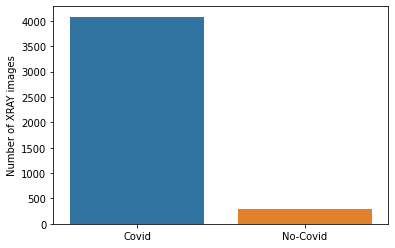

In [16]:
#Read images (COVID and non-COVID) from dataset
covid_files_xr = glob.glob(covid_path_xr + '/*.*')
noncovid_files_xr = glob.glob(noncovid_path_xr + '/*')

print("Total Covid XRAY image Count: ",len(covid_files_xr))
print("Total Non-Covid XRAY image Count: ",len(noncovid_files_xr))

fig = plt.figure()
ax = fig.add_subplot(111) 
x = ['Covid', 'No-Covid']
y = [len(covid_files_xr), len(noncovid_files_xr)]
ax = sns.barplot(x=x, y=y)
ax.set_ylabel('Number of XRAY images')



## **from the above we can see it is completely imbalanced data**
lets balance the No-Covid data set using the fast.ai’s apply_tfms method 

In [23]:
path_hr = '/content/AIML/NonCOVID'
il = ImageList.from_folder(path_hr)
tfms = get_transforms(max_rotate=25)
def data_aug_one(ex_img,prox,qnt):
   for lop in range(0,qnt):
      image_name = str(prox).zfill(8) +'.jpg'
      dest = path_hr+'/'+image_name
      prox = prox + 1
      new_img = open_image(ex_img)
      new_img_fin = new_img.apply_tfms(tfms[0], new_img, xtra={tfms[1][0].tfm: {"size": 224}}, size=224)
      new_img_fin.save(dest)
prox = 20
qnt = 14
for imagen in il.items:
   data_aug_one(imagen,prox,qnt)
   prox = prox + qnt

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

## lets recheck after non covid images are agumented and resampling is done

Total Covid XRAY image Count:  4083
Total Non-Covid XRAY image Count:  4230


Text(0, 0.5, 'Number of XRAY images')

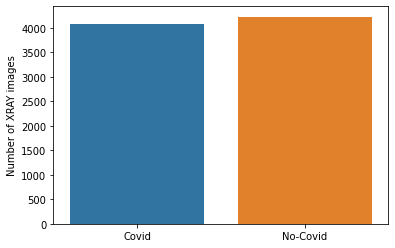

In [24]:
#Read images (COVID and non-COVID) from dataset
covid_files_xr = glob.glob(covid_path_xr + '/*.*')
noncovid_files_xr = glob.glob(noncovid_path_xr + '/*')

print("Total Covid XRAY image Count: ",len(covid_files_xr))
print("Total Non-Covid XRAY image Count: ",len(noncovid_files_xr))

fig = plt.figure()
ax = fig.add_subplot(111) 
x = ['Covid', 'No-Covid']
y = [len(covid_files_xr), len(noncovid_files_xr)]
ax = sns.barplot(x=x, y=y)
ax.set_ylabel('Number of XRAY images')

<Figure size 432x288 with 0 Axes>

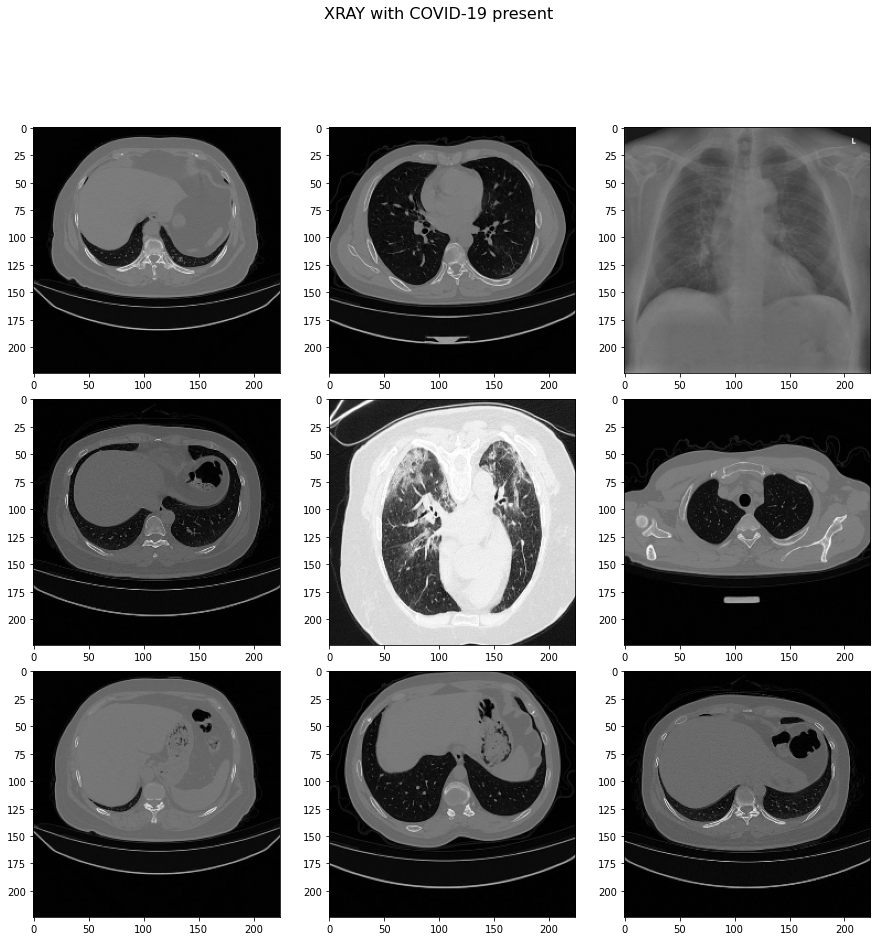

<Figure size 432x288 with 0 Axes>

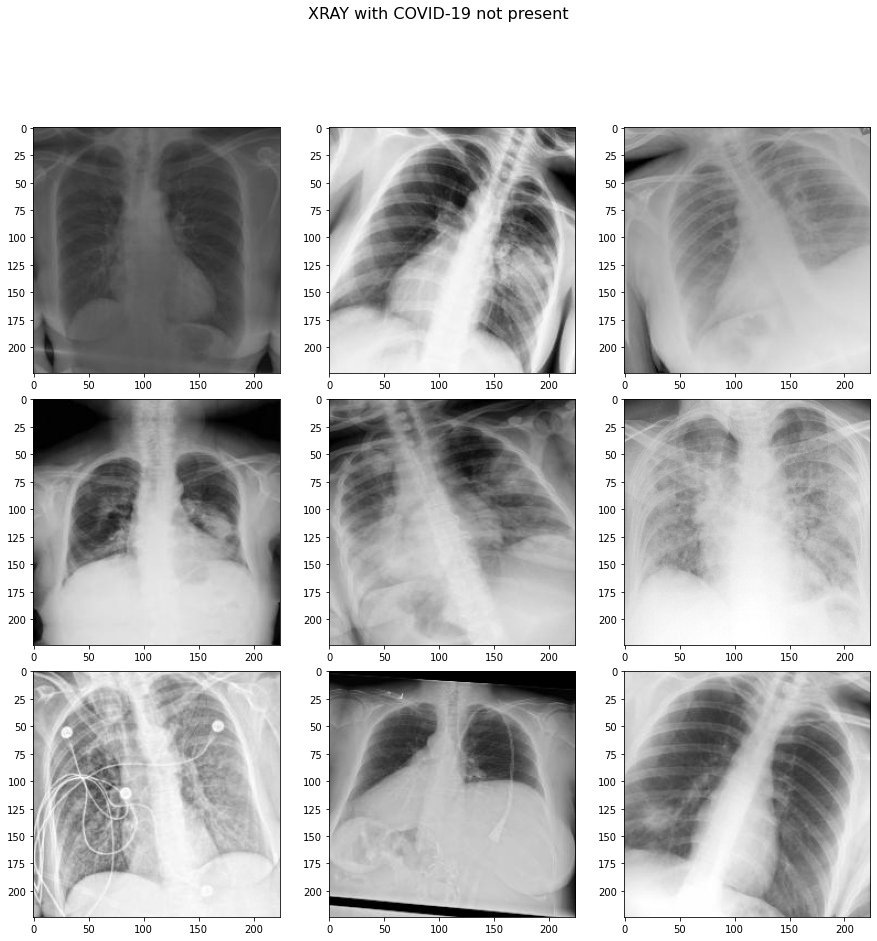

In [25]:
#Open and display a set of 9 XRAY images (COVID and non-COVID) from each dataset, resize images to 224x 224.
figsize = [10, 6]
fig = plt.figure()
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i, ax in enumerate(fig.axes):
  image = cv2.imread(covid_files_xr[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(224,224)) 

  ax= plt.subplot(3, 3, i+1)
  ax.imshow(image)
  plt.suptitle('XRAY with COVID-19 present', fontsize=16)
  plt.subplots_adjust(hspace=0)

fig = plt.figure()
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i, ax in enumerate(fig.axes):
  image = cv2.imread(noncovid_files_xr[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(224,224)) 

  ax= plt.subplot(3, 3, i+1)
  ax.imshow(image)
  plt.suptitle('XRAY with COVID-19 not present', fontsize=16)
  plt.subplots_adjust(hspace=0)
  
  

Covid XRAY Image mean:   [44.804298400878906, 44.804298400878906, 44.804298400878906]
Covid XRAY Image min, max:   [(0, 255), (0, 255), (0, 255)]
Covid XRAY Image variance:   [2521.0134586966014, 2521.0134586966014, 2521.0134586966014]
Covid XRAY Image stdev:   [50.209694867591075, 50.209694867591075, 50.209694867591075]





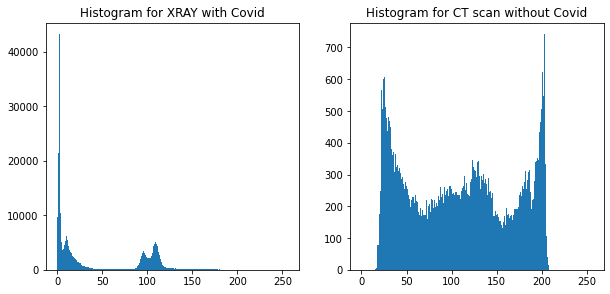

In [29]:
#Load a Xray image. Estimate image statistics- max, min pixel values, mean, standard deviation. 
#Plot histogram of image intensities.
import PIL.Image
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221) 


i= r.randint(0, len(covid_files_xr))
im1 = cv2.imread(covid_files_xr[i],cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([im1],[0],None,[256],[0,256])
ax1.hist(im1.ravel(),256,[0,256])
ax1.set_title('Histogram for XRAY with Covid')


ax2 = fig.add_subplot(222) 


j= r.randint(0, len(noncovid_files_xr))
im2 = cv2.imread(noncovid_files_xr[j],cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([im2],[0],None,[256],[0,256])
ax2.hist(im2.ravel(),256,[0,256])
ax2.set_title('Histogram for CT scan without Covid')

im_ctstat = PIL.Image.open(covid_files_xr[i])
stat = Stat(im_ctstat)
print("Covid XRAY Image mean:  ", stat.mean)    
print("Covid XRAY Image min, max:  ", stat.extrema) 
print("Covid XRAY Image variance:  ",stat.var)     
print("Covid XRAY Image stdev:  ",stat.stddev)     
print("\n\n")  

Now convert the images from the Covid and Non Covid directories to Dicom format using the Simple ITK library

Read in Covid image paths using glob

In [30]:
images = glob.glob("/content/AIML/COVID/*")
print(len(images))

4083


Save Covid images in .dcm format in another directory named e.g. cov_chest

In [31]:
import numpy as np
import SimpleITK as sitk

count=0
for image in images:
  im1 = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  im1= np.array(im1)
  img= sitk.GetImageFromArray(im1)
  img = sitk.GetImageFromArray(im1)
  sitk.WriteImage(img,'/content/AIML/processed_cov/covidchest_'+ str(count)+'.dcm')
  count =count+1
  print(count)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Read in NonCovid image paths using glob

In [32]:
images_noncovid = glob.glob("/content/AIML/NonCOVID/*")
len(images_noncovid)


4230

Save NonCovid images in .dcm format in another directory named, e.g. nocov_chest

In [33]:
count1=0

for image in images_noncovid:
  im1 = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  im1= np.array(im1)
  img= sitk.GetImageFromArray(im1)
  img = sitk.GetImageFromArray(im1)
  sitk.WriteImage(img,'/content/AIML/processed_noncov/nocovidchest_'+ str(count1)+'.dcm')
  count1 =count1+1
  print(count1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [34]:
files = []
labels = []
df_target = pd.DataFrame(columns=['image_path', 'target'])

for file1 in sorted(os.listdir(proc_cov)):
    files.append(proc_cov+'/'+file1)
    labels.append(str(0)) #Chest_COVID': 0, 'Chest_NonCOVID': 1

for file2 in sorted(os.listdir(proc_noncov)):
    files.append(proc_noncov+'/'+file2)   
    labels.append(str(1)) #Chest_COVID': 0, 'Chest_NonCOVID': 1

df_target['image_path']=files
df_target['target']=labels

Save the dataframe in a CSV file

In [35]:
df_target.to_csv(aiml_dir+'/chest_data.csv', index=False)

Once you have the directories with Covid and Noncovid images in Dicom format and the CSV file, you are ready to go to the next part of VGG16 model building and training

In [36]:
df_target.target.value_counts()

1    4230
0    4083
Name: target, dtype: int64

In [37]:
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
              
        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array

In [38]:
df_target

image_path target
0          /content/AIML/processed_cov/covidchest_0.dcm      0
1          /content/AIML/processed_cov/covidchest_1.dcm      0
2         /content/AIML/processed_cov/covidchest_10.dcm      0
3        /content/AIML/processed_cov/covidchest_100.dcm      0
4       /content/AIML/processed_cov/covidchest_1000.dcm      0
...                                                 ...    ...
8308  /content/AIML/processed_noncov/nocovidchest_99...      1
8309  /content/AIML/processed_noncov/nocovidchest_99...      1
8310  /content/AIML/processed_noncov/nocovidchest_99...      1
8311  /content/AIML/processed_noncov/nocovidchest_99...      1
8312  /content/AIML/processed_noncov/nocovidchest_99...      1

[8313 rows x 2 columns]

In [39]:
#Create the train and test dataframes by splitting the loaded dataframe
# split for testing
train_df, test_df = train_test_split(df_target, test_size=0.2)

# augmentation parameters
# you can use preprocessing_function instead of rescale 
train_augmentation_parameters = dict(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=1.0/255.0
)

In [40]:
#Set the training parameters. Note that the CLASS_MODE has to be 'categorical' and the COLOR_MODE has to be 'rgb'. 
#Keep the TARGET_SIZE to be (224, 224)
# Also similarly set the validation and test parameters.

# training parameters
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 100
#SEED = 1337

train_consts = {
    
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 9,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}

In [41]:
#Create the train and validation augmenter with the provided parameters. You will pass 
#these to the image_data_generator argument of the DCMDataFrameIterator class for creating the train and validation generators.

train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)

In [42]:
#remove all .ipynb_checkpoints created during github clone otherwise ther are treated as one more class variable
!rm -rf `find -type d -name .ipynb_checkpoints`

In [43]:
#Now create the train and valid generator using the DCMDataFrameIterator class
train_generator = DCMDataFrameIterator(dataframe=train_df,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=train_augmenter,
                             **train_consts)

valid_generator = DCMDataFrameIterator(dataframe=train_df,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=valid_augmenter,
                             **valid_consts)

Found 5320 validated image filenames belonging to 2 classes.
Found 1330 validated image filenames belonging to 2 classes.


In [44]:
#Check shape of the X,Y (image, target) data that is loaded in the train generator
x, y = train_generator.next()

print(x.shape)
print(y.shape)

(32, 224, 224, 3)
(32,)


In [45]:
#Build a VGG 16 model from scratch and train using XRAY images
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="sigmoid"))

In [46]:
#Compile the model. Important here is the type of loss used
from tensorflow.keras.optimizers import Adam, SGD
opt = Adam(learning_rate=0.00001)
#opt= SGD(learning_rate=0.00001)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [47]:
#Generate model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [50]:
#Now use the model and the train / valid generator to train the VGG16 model
#commenting checkpoint and earlystopping as getting warning
#WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
#as it is taking long time reduced number of epochs from 100 to 20
from keras.callbacks import ModelCheckpoint, EarlyStopping

#checkpoint = ModelCheckpoint("vgg16_XR_MS2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
#early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit_generator(
	generator=train_generator,
	steps_per_epoch=len(train_generator),
	epochs=20,#EPOCHS,
	validation_data=valid_generator,
	validation_steps=len(valid_generator)#,callbacks=[checkpoint,early]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
167/167 [==============================] - 160s 955ms/step - loss: 0.1570 - accuracy: 0.9365 - val_loss: 0.2219 - val_accuracy: 0.9150
Epoch 2/20
167/167 [==============================] - 157s 939ms/step - loss: 0.1516 - accuracy: 0.9442 - val_loss: 0.1255 - val_accuracy: 0.9481
Epoch 3/20
167/167 [==============================] - 156s 931ms/step - loss: 0.1451 - accuracy: 0.9440 - val_loss: 0.1657 - val_accuracy: 0.9301
Epoch 4/20
167/167 [==============================] - 156s 932ms/step - loss: 0.1434 - accuracy: 0.9432 - val_loss: 0.1302 - val_accuracy: 0.9556
Epoch 5/20
167/167 [==============================] - 156s 931ms/step - loss: 0.1289 - accuracy: 0.9476 - val_loss: 0.1139 - val_accuracy: 0.9556
Epoch 6/20
167/167 [==============================] - 156s 931ms/step - loss: 0.1277 - accuracy: 0.9515 - val_loss: 0.1780 - val_accuracy: 0.9301
Epoch 7/20
167/167 [==============================] - 156s 931ms/step - loss: 0.1248 - accuracy: 0.9521 - val_loss: 0.1160 -

In [51]:
model.save_weights(aiml_dir+"/vgg16_model.h5")

In [62]:
#!gzip /content/AIML/vgg16_model.h5
#!gunzip /content/AIML/vgg16_model.h5.gz

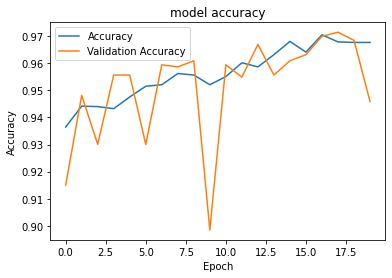

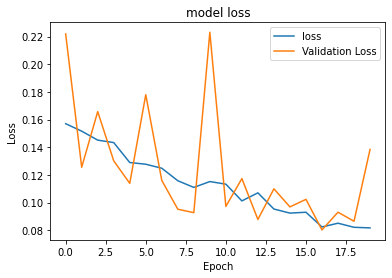

In [55]:
#Test the model performance by predicting on validation data and plotting learning curves
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [56]:
#Predict on random images from test set.
test_augmenter = ImageDataGenerator(**test_augmentation_parameters)
test_generator = DCMDataFrameIterator(dataframe=test_df,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=test_augmenter,
                             **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

Found 1663 validated image filenames belonging to 2 classes.
185/185 [==============================] - 28s 141ms/step - loss: 0.1480 - accuracy: 0.9357


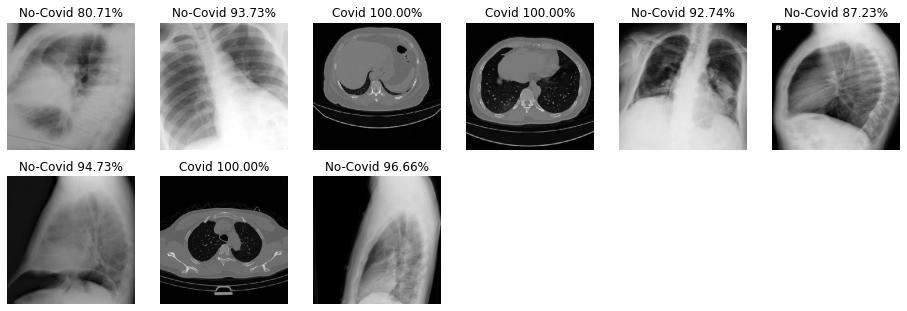

In [57]:
import matplotlib.pyplot as plt

x, y = test_generator.next()

plt.figure(figsize=(16, 8))
for i in range(9):
    prediction = model.predict(np.expand_dims(x[i], axis=0))[0]
    
    plt.subplot(3, 6, i+1)
    if prediction[0] > prediction[1]:
        plt.title('Covid %.2f%%' % (prediction[0]*100))
    else:
        plt.title('No-Covid %.2f%%' % (prediction[1]*100))
    
    plt.axis('off')
    plt.imshow(x[i])

In [58]:
#Save the model. It is the best practice of converting the model into JSON format to save it for the inference program in the future.
model_json = model.to_json()
with open("/content/AIML/vgg16_model.json","w") as json_file:
  json_file.write(model_json)

In [59]:
def predict_covid(image_path):
    #Load the Model from Json File
    json_file = open(aiml_dir+'/vgg16_model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights(aiml_dir+'/vgg16_model.h5')
    #Compile the model
    opt = Adam(learning_rate=0.00001) #, momentum=0.9
    #model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model_c.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    #cv2_imshow(image)
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if preds=='0':
        print("Predicted Label:Covid19")
    else:
        print("Predicted Label: NonCovid")

/content/covid-chestxray-dataset/images/a4318ac9.jpg


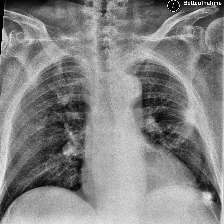

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/6646071b.jpg


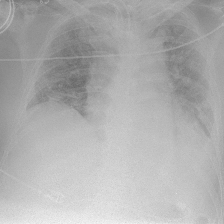

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/5359825d.jpg


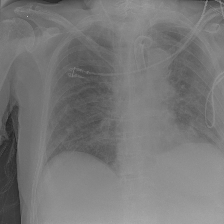

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/0cd9fcb6.jpg


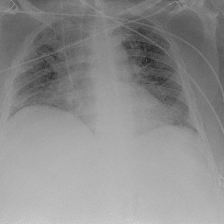

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/ce09cfab.jpg


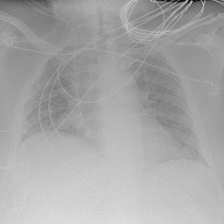

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/b0500187.jpg


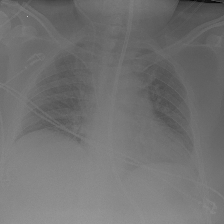

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/40f355ec.jpg


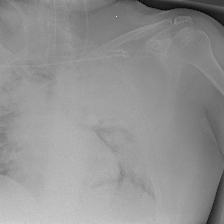

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/e6eaadf0.jpg


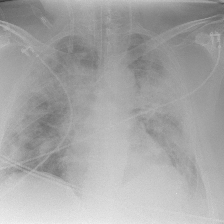

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/34d999a9.jpg


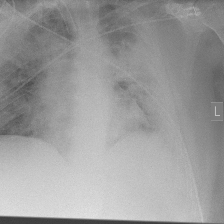

Predicted Label: NonCovid
/content/covid-chestxray-dataset/images/fbb18dc0.jpg


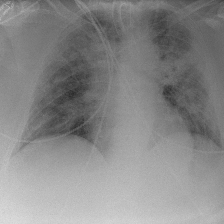

Predicted Label: NonCovid


In [63]:
## there are few images which are with todo or unknown finding. lets test and see how those images perforam
normal=["todo","Unknown"]
cnt=0
for index, row in df.iterrows():    
    if row['folder']!='images':      
      continue
    elif  find_all(row['filename'],images_dir)!='Y' :
      continue
    elif (row['finding']=='todo') or (row['finding']=='Unknown') :
      img=row['filename']
      print(images_dir+'/'+img)
      predict_covid(images_dir+'/'+img)
      cnt=cnt+1
      if cnt>=10 :
        break

In [64]:
!gzip /content/AIML/vgg16_model.h5

In [65]:
from google.colab import files
files.download('/content/AIML/vgg16_model.h5.gz') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>